In [1]:
import pandas as pd

selected_stocks_df = pd.read_csv('selected_stocks_financials.csv')
tickers = selected_stocks_df['symbol'].tolist()

In [20]:
from newsapi import NewsApiClient

news_api_key = 'cb0a43dc942a49e0a09f1e46843672a4'  # Replace with your NewsAPI key
newsapi = NewsApiClient(api_key=news_api_key)

news_data = {}
for ticker in tickers:
    news_articles = newsapi.get_everything(q=ticker, language='en', sort_by='relevancy')
    news_data[ticker] = news_articles['articles']


news_data_cleaned = {}

for ticker, articles in news_data.items():
    cleaned_articles = []
    for article in articles:
        title = clean_text(article['title'])
        title = remove_stopwords(title)
        cleaned_articles.append(title)
    news_data_cleaned[ticker] = cleaned_articles


sentiment_data = {}

for ticker, articles in news_data_cleaned.items():
    sentiment_scores = []
    for article in articles:
        sentiment = TextBlob(article).sentiment.polarity
        sentiment_scores.append(sentiment)
    sentiment_data[ticker] = sentiment_scores

avg_sentiment_data = {}

for ticker, scores in sentiment_data.items():
    if len(scores) > 0:
        avg_sentiment = sum(scores) / len(scores)
    else:
        avg_sentiment = 0
    avg_sentiment_data[ticker] = avg_sentiment



In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)


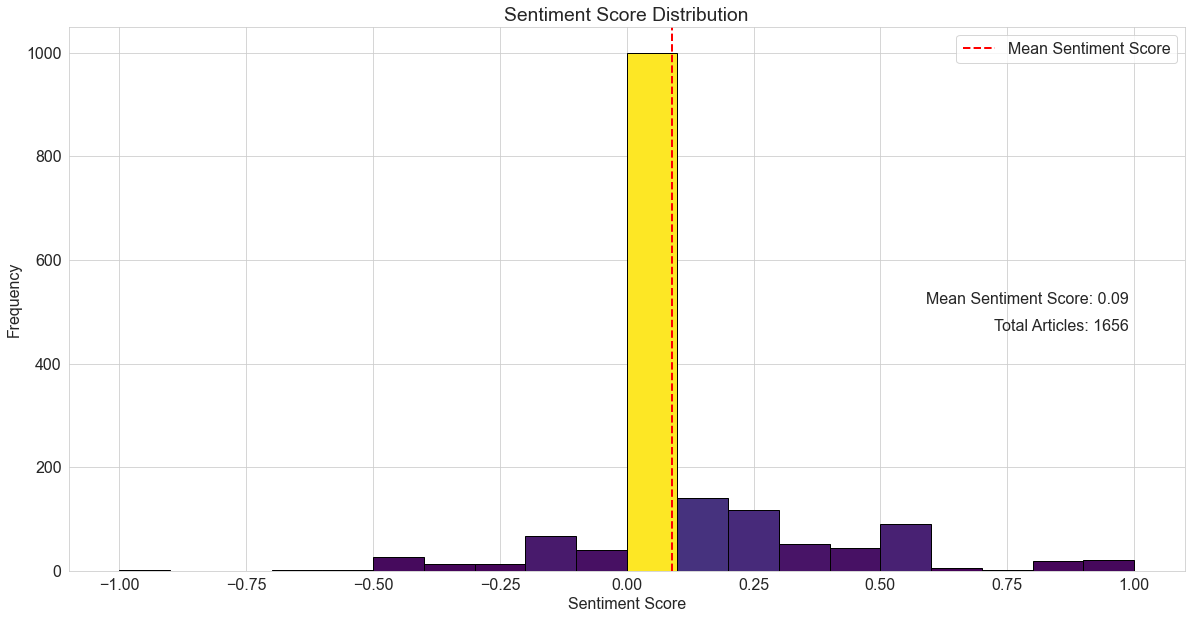

In [67]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})

# Flatten sentiment scores into a single list
sentiment_scores_list = [score for scores in sentiment_data.values() for score in scores]

# Create a histogram plot
fig, ax = plt.subplots(figsize=(20, 10)) 
n, bins, patches = ax.hist(sentiment_scores_list, bins=20, edgecolor='black')

# Set x and y axis labels and title
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
ax.set_title('Sentiment Score Distribution')

# Customize the color of the histogram bars
fracs = n / n.max()
norm = plt.Normalize(fracs.min(), fracs.max())
for patch, color in zip(patches, plt.cm.viridis(norm(fracs))):
    patch.set_facecolor(color)

# Add a line indicating the mean sentiment score
mean_sentiment_score = np.mean(sentiment_scores_list)
ax.axvline(mean_sentiment_score, color='red', linestyle='dashed', linewidth=2, label='Mean Sentiment Score')
ax.legend()

# Add text annotations for the mean sentiment score and the total number of articles
ax.text(0.95, 0.5, f'Mean Sentiment Score: {mean_sentiment_score:.2f}', transform=ax.transAxes, ha='right', va='center')
ax.text(0.95, 0.45, f'Total Articles: {len(sentiment_scores_list)}', transform=ax.transAxes, ha='right', va='center')

# Show the plot
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_18128\3156802416.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm)


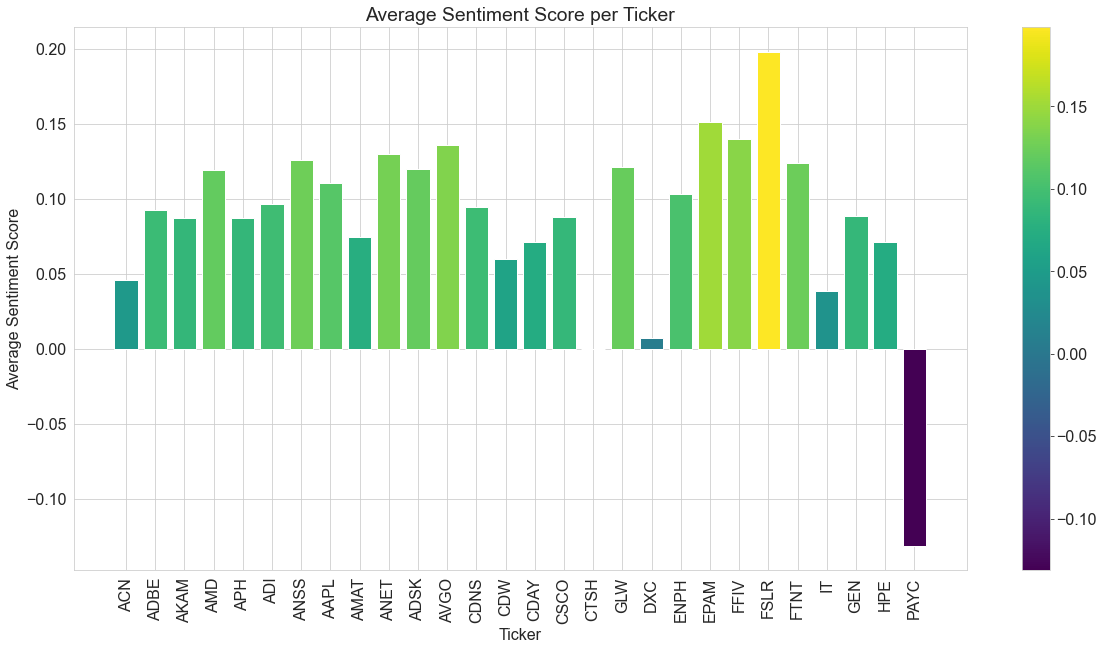

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Define the colormap
cmap = plt.get_cmap('viridis')

plt.rcParams.update({'font.size': 16})

# Get the tickers and sentiment scores
tickers = list(avg_sentiment_data.keys())
sentiment_scores = list(avg_sentiment_data.values())

# Get the positions of the bars on the x-axis
x_pos = np.arange(len(tickers))

# Map the sentiment scores to colors
colors = cmap(np.interp(sentiment_scores, (min(sentiment_scores), max(sentiment_scores)), (0, 1)))

# Create the bar plot
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.bar(x_pos, sentiment_scores, color=colors)

# Set the labels and title
ax.set_xlabel('Ticker')
ax.set_ylabel('Average Sentiment Score')
ax.set_title('Average Sentiment Score per Ticker')

# Set the tick labels
ax.set_xticks(x_pos)
ax.set_xticklabels(tickers, rotation=90)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(sentiment_scores), vmax=max(sentiment_scores)))
sm._A = []
cbar = plt.colorbar(sm)

# Show the plot
plt.show()


In [69]:
import pandas as pd

# Load the selected stocks financials CSV file
selected_stocks_df = pd.read_csv('selected_stocks_financials.csv')

# Create a new DataFrame to hold the sentiment scores
sentiment_df = pd.DataFrame.from_dict(avg_sentiment_data, orient='index', columns=['sentiment_score'])

# Merge the sentiment scores DataFrame with the selected stocks DataFrame on the 'symbol' column
selected_stocks_df = pd.merge(selected_stocks_df, sentiment_df, left_on='symbol', right_index=True)

# Save the updated DataFrame to a new CSV file
selected_stocks_df.to_csv('selected_stocks_financials_sentiment.csv', index=False)